In [0]:
%matplotlib inline
import pandas as pd
import numpy as cupy
#import cupy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns
import sklearn.preprocessing as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from tensorflow import keras  
import tensorflow as tf

In [0]:
# 初期設定変更
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

# 分析対象データの把握と方針

|  カラム  |  意味  |  単位/型  |  方針  |
| ---- | ---- | ---- | ---- |
|  ID  |  キックスタータID  |  index  |  使用しない  |
|  name  |  プロジェクト名  |  String  |  特徴量抽出後、削除  |
|  category  |  カテゴリ  |  String  |  ダミー変数にすると計算量が多くなるため、使用しない  |
|  main_category  |  キャンペーンのカテゴリ  |  String  |  ダミー変数に変換  |
|  currency  |  支援通貨  |  String  |  countryと強い相関があるため使用しない  |
|  deadline  |  クラウドファンディングの締切  |  Date  |  特徴量抽出後、削除  |
|  goal  |  資金調達目標 - 作成者がプロジェクトを完了するために必要な金額  |  数値  |  usd_goal_realを使用（本来であれば通貨とDateからUSドル換算？）  |
|  launched  |  開始日  | Date |  特徴量抽出後、削除  |
|  pledged  |  「群衆」が約束した金額  |  数値  |  予測時点では使用できないため、使用不可  |
|  state  |  プロジェクトの現状  |  String  |  目的変数[Successful/Failed）]とする  |
|  backers  |  支持者の数  |  数値  |  予測時点では使用できないため、使用不可  |
|  country  |  国  |  String  |  ダミー変数に変換  |
|  usd pledged  |  USドル換算額 (conversion made by KS)  |  数値  |  使用しない。pledgedと同じ  |
|  usd_pledged_real  |  USドル換算額 (conversion made by fixer.io api)  |  数値  |  使用しない。pledgedと同じ  |
|  usd_goal_real  |  目標額USドル (conversion made by fixer.io api)  |  数値  |  goalの変わりに使う  |
|  period  |  期間（deadline - launched） |  日  |  新しい特徴量  |
|  name_len  |  'name'から文字数カウント  |  個  |  新しい特徴量  |
|  name_split  |  'name'から単語数カウント  |  個  |  新しい特徴量→name_lenと強い相関があるため使用しない  |
|  dayofweek  |  曜日  |  String  |  新しい特徴量  |
|  month  |  月  |  String  |  新しい特徴量  |

In [0]:
# データ読込
# df_cloud = pd.read_csv(
#     "./input/ks-projects-201801.csv", dtype = None, delimiter = ",")[
#     ['category', 'main_category', 'currency', 'goal', 'state', 'country', 'launched', 'deadline']]
df_cloud = pd.read_csv(
    "/content/ks-projects-201801.csv", dtype = None, delimiter = ",")[
    ['name', 'category', 'main_category', 'usd_goal_real', 'state', 'country', 'launched', 'deadline']]

In [0]:
#成功と失敗の二値に分類

#stateを文字列から数値型へ
def statetype(in_string):
    if in_string == "successful":
        return 0
    elif in_string == "failed":
        return 1
    else :
        pass
        
df_cloud['state_num']= df_cloud['state'].apply(statetype)

In [0]:
#'name'から特徴量'name_len'(文字数)抽出
df_cloud['name_len'] = df_cloud['name'].apply(lambda x: len(str(x).replace(' ', '')))

In [0]:
#'name'から特徴量'name_split'(単語数)抽出
# df_cloud['name_split'] = df_cloud['name'].apply(lambda x: len(str(x).split()))

文字数カウントも単語数カウントも似た特徴量であり、強い相関があるため、片方削除

In [0]:
#欠損値データを削除
df_cloud.dropna(inplace=True)

In [0]:
#'country'の不正データN,0"対応
df_cloud = df_cloud[df_cloud['country'] != 'N,0"']

In [0]:
#新しい特徴量を作成（'launched'を曜日に変換）
df_cloud['dayofweek'] = pd.to_datetime(df_cloud['launched']).dt.strftime('%A')
#新しい特徴量を作成（'launched'を月に変換）
df_cloud['month'] = pd.to_datetime(df_cloud['launched']).dt.strftime('%b')

In [10]:
df_cloud['dayofweek'].value_counts()

Tuesday      67658
Wednesday    59140
Monday       53472
Thursday     53082
Friday       51306
Saturday     28534
Sunday       18270
Name: dayofweek, dtype: int64

In [11]:
df_cloud['month'].value_counts()

Jul    32007
Mar    30031
Oct    29375
May    29163
Jun    28973
Nov    28503
Apr    28452
Aug    28405
Sep    27406
Feb    26273
Jan    24412
Dec    18462
Name: month, dtype: int64

In [0]:
#質的変数をダミー変数に変換
df_dummy = pd.get_dummies(df_cloud, columns=['main_category', 'country', 'dayofweek', 'month'])

In [0]:
#新しい特徴量（資金調達率、期間）を作成
df_dummy['period'] = pd.to_datetime(df_cloud['deadline']).map(pd.Timestamp.timestamp) - pd.to_datetime(df_cloud['launched']).map(pd.Timestamp.timestamp)

In [0]:
#評価対象のみに絞る
df_dummy=df_dummy.drop(['name', 'category', 'state', 'launched', 'deadline'],axis=1)

In [15]:
df_dummy.info()
display(df_dummy.head())
df_dummy.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 0 to 378660
Data columns (total 60 columns):
usd_goal_real                 331462 non-null float64
state_num                     331462 non-null float64
name_len                      331462 non-null int64
main_category_Art             331462 non-null uint8
main_category_Comics          331462 non-null uint8
main_category_Crafts          331462 non-null uint8
main_category_Dance           331462 non-null uint8
main_category_Design          331462 non-null uint8
main_category_Fashion         331462 non-null uint8
main_category_Film & Video    331462 non-null uint8
main_category_Food            331462 non-null uint8
main_category_Games           331462 non-null uint8
main_category_Journalism      331462 non-null uint8
main_category_Music           331462 non-null uint8
main_category_Photography     331462 non-null uint8
main_category_Publishing      331462 non-null uint8
main_category_Technology      331462 non-null uint8
m

,usd_goal_real,state_num,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,...,country_NO,country_NZ,country_SE,country_SG,country_US,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,period
0,1533.95,1.0,26,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,5053652.0
1,30000.00,1.0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5166963.0
2,45000.00,1.0,12,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3886750.0
3,5000.00,1.0,43,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2579749.0
5,50000.00,0.0,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2974893.0


,usd_goal_real,state_num,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,...,country_NO,country_NZ,country_SE,country_SG,country_US,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,period
count,3.314620e+05,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,...,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,3.314620e+05
mean,4.152286e+04,0.596180,29.566107,0.077354,0.029801,0.023586,0.010780,0.076519,0.059657,0.170466,0.066536,0.086043,0.012514,0.138179,0.029231,0.106839,0.081596,0.030899,0.001463,0.019960,0.001578,0.037320,0.001967,0.010366,0.002794,...,0.001756,0.003844,0.004553,0.001370,0.788501,0.154787,0.161322,0.086085,0.055119,0.160145,0.204120,0.178422,0.085838,0.085696,0.055699,0.079264,0.073649,0.096563,0.087410,0.090602,0.087983,0.085992,0.088623,0.082682,2.884932e+06
std,1.109279e+06,0.490663,13.463769,0.267153,0.170039,0.151757,0.103263,0.265826,0.236850,0.376042,0.249216,0.280428,0.111165,0.345088,0.168454,0.308909,0.273749,0.173046,0.038224,0.139863,0.039691,0.189544,0.044308,0.101286,0.052782,...,0.041866,0.061877,0.067319,0.036984,0.408372,0.361702,0.367828,0.280490,0.228214,0.366741,0.403058,0.382868,0.280125,0.279915,0.229339,0.270151,0.261200,0.295362,0.282435,0.287042,0.283271,0.280352,0.284199,0.275402,1.099363e+06
min,1.000000e-02,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.370000e+02
25%,2.000000e+03,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.513282e+06
50%,5.000000e+03,1.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.562364e+06
75%,1.500000e+04,1.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [0]:
# 散布図行列を書いてみる
# pd.plotting.scatter_matrix(df_dummy, figsize=(10,10))
# plt.show()

In [17]:
# 特徴選択の結果から'main_category_Design'を削除
df_dummy.drop('main_category_Design', axis=1)

,usd_goal_real,state_num,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,...,country_NO,country_NZ,country_SE,country_SG,country_US,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,period
0,1533.95,1.0,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,5053652.0
1,30000.00,1.0,38,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5166963.0
2,45000.00,1.0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3886750.0
3,5000.00,1.0,43,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2579749.0
5,50000.00,0.0,18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2974893.0
6,1000.00,0.0,52,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1661356.0
7,25000.00,1.0,42,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3815688.0
10,2406.39,1.0,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2526023.0
11,12500.00,0.0,13,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2567822.0
12,5000.00,1.0,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2530090.0


In [18]:
# 相関係数を確認
df_dummy.corr()

,usd_goal_real,state_num,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,...,country_NO,country_NZ,country_SE,country_SG,country_US,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,period
usd_goal_real,1.000000e+00,0.023732,-0.005017,-0.000546,-0.003370,-0.004423,-0.003123,-0.000852,-0.004459,0.014140,0.001599,-0.000712,0.002901,-0.009773,-0.004759,-0.007473,0.015166,-0.002960,0.000021,0.001802,-0.000216,0.000585,0.010612,0.003321,-0.000958,...,0.000104,-0.000977,-0.000168,-0.000889,-0.003784,0.000433,0.000473,-0.002020,-0.002106,0.001424,0.002257,-0.001867,-0.000692,0.005073,0.002327,0.000523,-0.001320,0.001084,-0.000958,-0.002067,0.000559,-0.000931,-0.003200,1.753783e-07,0.021557
state_num,2.373235e-02,1.000000,-0.100420,-0.026607,-0.067008,0.042221,-0.053301,-0.007099,0.062101,-0.012998,0.069597,-0.021949,0.036674,-0.099951,0.022178,0.039819,0.100822,-0.085209,0.014293,0.029089,0.009171,0.027939,0.010587,0.027350,0.001624,...,0.010725,0.006605,0.009167,0.000887,-0.056574,0.013929,-0.002540,0.018317,-0.000248,0.001418,-0.021988,-0.002201,-0.011952,0.014289,0.016444,-0.008955,0.008900,0.025898,-0.001592,-0.014671,-0.006043,-0.005701,-0.010553,-3.659464e-03,0.116616
name_len,-5.017301e-03,-0.100420,1.000000,-0.000512,-0.021182,-0.012964,0.011799,0.078565,0.013962,-0.127569,-0.010467,-0.047133,-0.005604,0.044700,-0.001091,0.034604,0.052664,0.025243,0.000982,-0.002050,-0.004421,-0.012338,0.003803,0.014168,-0.006327,...,-0.008711,-0.000812,-0.008073,0.012105,0.022243,-0.007555,-0.003469,-0.006680,-0.000819,-0.000109,0.013885,0.001339,0.000063,-0.004461,-0.005207,-0.010680,-0.008963,-0.012983,0.008247,-0.004955,0.004672,0.013944,0.009874,9.226126e-03,0.014382
main_category_Art,-5.456868e-04,-0.026607,-0.000512,1.000000,-0.050747,-0.045003,-0.030226,-0.083348,-0.072931,-0.131258,-0.077304,-0.088842,-0.032596,-0.115941,-0.050245,-0.100144,-0.086306,-0.051703,-0.002516,-0.010478,-0.000130,-0.001184,-0.001640,-0.008339,0.000079,...,-0.003782,-0.003203,-0.001967,-0.004616,0.006384,0.004098,-0.000377,0.002084,0.000878,0.004831,-0.008311,-0.001437,-0.000600,0.004266,-0.003403,0.001867,-0.000838,0.005396,0.001792,0.003815,0.002516,-0.007485,-0.006647,-1.639027e-03,-0.037129
main_category_Comics,-3.370165e-03,-0.067008,-0.021182,-0.050747,1.000000,-0.027240,-0.018295,-0.050449,-0.044144,-0.079449,-0.046791,-0.053775,-0.019730,-0.070178,-0.030412,-0.060616,-0.052240,-0.031295,-0.003924,-0.003954,-0.003838,0.009769,-0.005378,-0.010405,-0.005579,...,-0.000570,-0.006585,-0.005263,-0.003133,0.016084,-0.001716,0.008898,0.004975,0.008749,-0.010639,-0.001510,-0.004006,-0.000944,0.002630,-0.014946,0.000199,-0.002752,-0.003355,0.000475,0.003217,0.002625,-0.002115,0.009214,2.851788e-03,-0.001259
main_category_Crafts,-4.423076e-03,0.042221,-0.012964,-0.045003,-0.027240,1.000000,-0.016224,-0.044739,-0.039147,-0.070456,-0.041495,-0.047688,-0.017496,-0.062234,-0.026970,-0.053754,-0.046327,-0.027753,-0.001269,-0.000149,0.003338,0.007576,0.001625,-0.000205,0.001190,...,-0.000345,0.001591,-0.000765,0.007145,-0.009809,0.000653,0.005285,-0.000072,0.000529,-0.003524,-0.001668,-0.000826,-0.006038,0.008454,-0.002120,-0.000418,0.004811,0.006466,-0.006994,0.000601,-0.009253,0.001682,0.002529,-2.954322e-05,-0.030815
main_category_Dance,-3.123413e-03,-0.053301,0.011799,-0.030226,-0.018295,-0.016224,1.000000,-0.030048,-0.026293,-0.047321,-0.027870,-0.032029,-0.011751,-0.041799,-0.018114,-0.036104,-0.031115,-0.

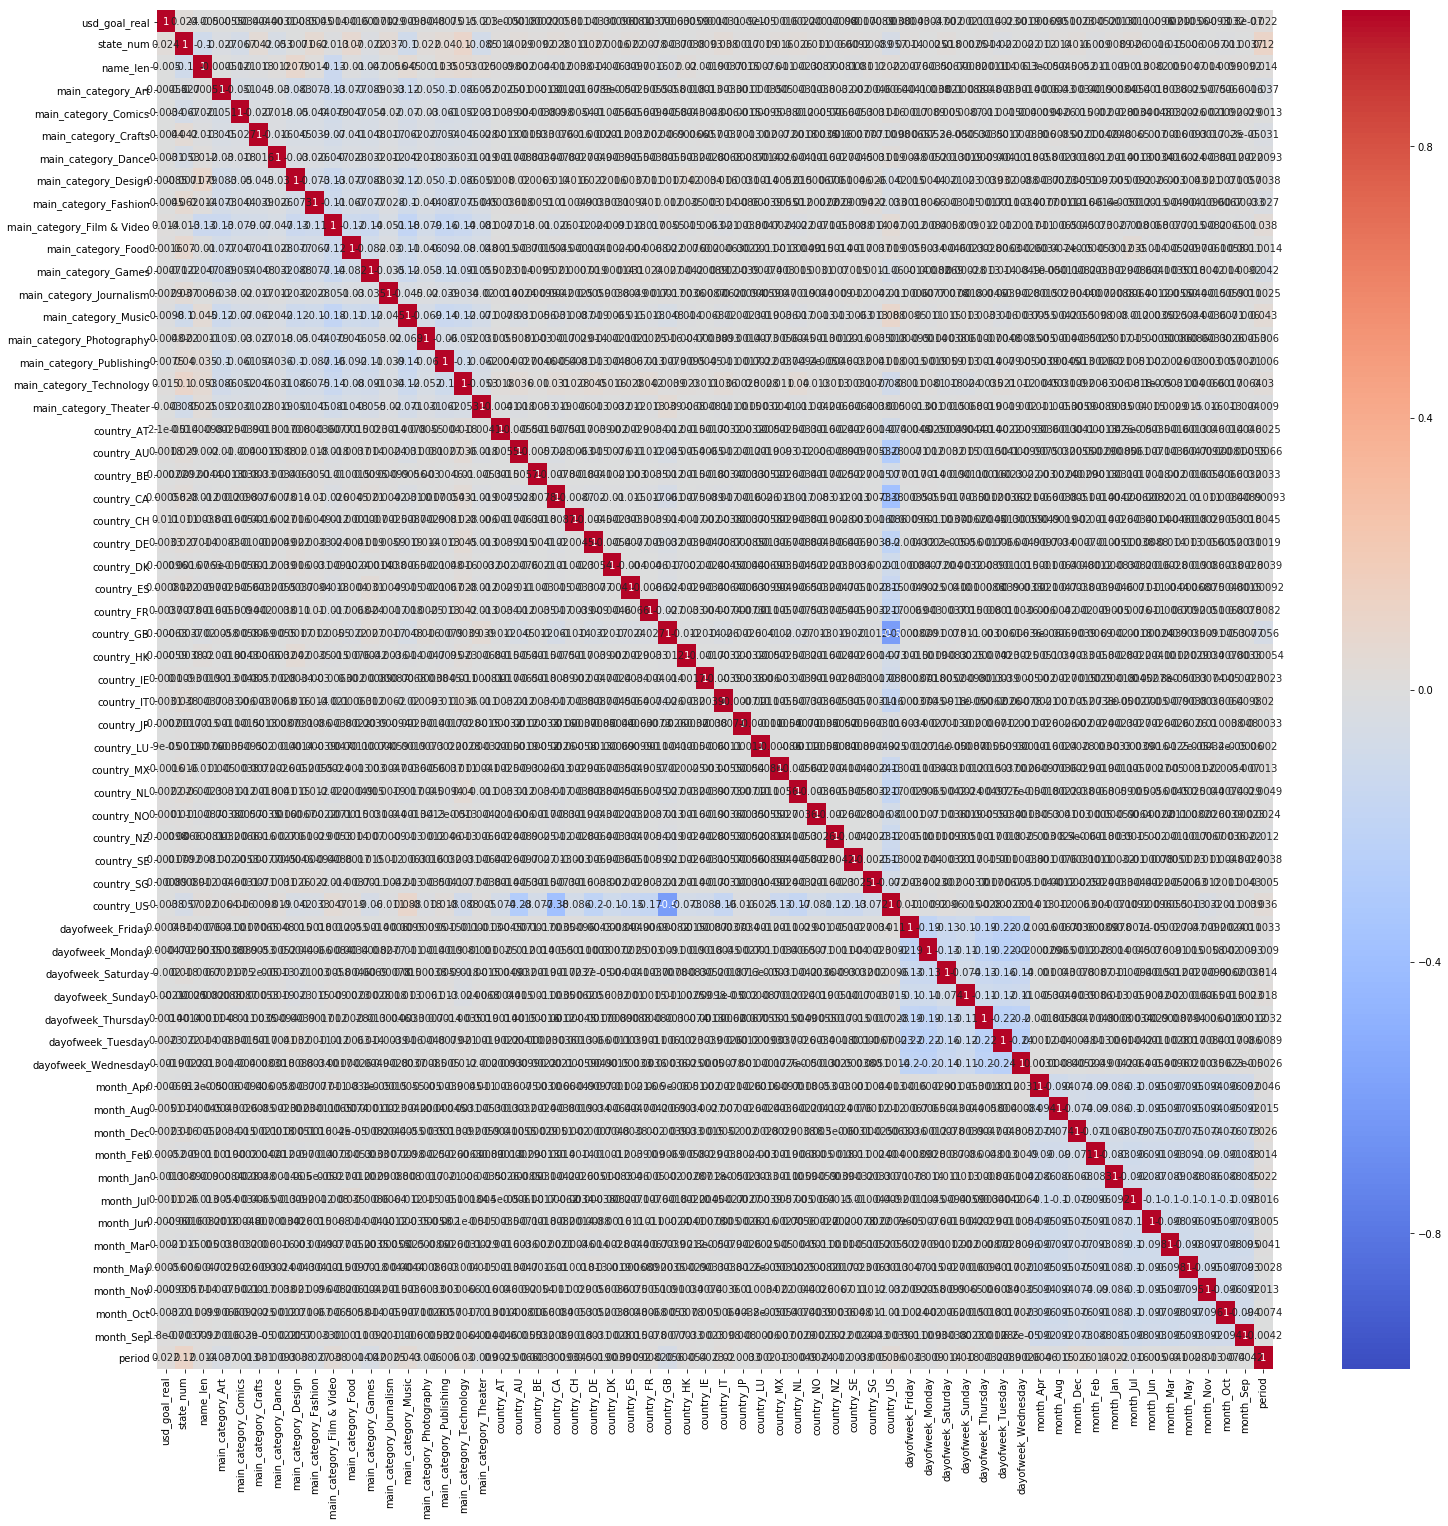

In [19]:
# 相関係数をヒートマップにして可視化
fig = plt.figure(figsize=(25, 25))
sns.heatmap(df_dummy.corr(), cmap='coolwarm', annot=True, vmax=1, vmin=-1,)
plt.show()

# 特徴選択

In [0]:
# estimatorにモデルをセット
# 今回は分類問題であるためロジスティック回帰を使用
# estimator = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1111, tol=1e-3)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 回帰:neg_mean_absolute_error, 分類:accuracyを評価指標に指定
# rfecv = RFECV(estimator, cv=2, scoring='accuracy')

In [0]:
#ホールドアウト法
train_label = df_dummy["state_num"]
train_data = df_dummy.drop('state_num', axis=1)

y = train_label.values
X = train_data.values

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

# 標準化
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

In [0]:
# fitで特徴選択を実行
# rfecv.fit(X_train, y_train)

In [0]:
# 特徴のランキングを表示（1が最も重要な特徴）
# print('Feature ranking: \n{}'.format(rfecv.ranking_))

In [0]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [0]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
# rfecv.support_

In [0]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
# remove_idx = ~rfecv.support_
# remove_idx

In [0]:
# 削除してもよい特徴の名前を取得する
# remove_feature = train_data.columns[remove_idx]
# remove_feature

In [0]:
# drop関数で特徴を削除
# selected_train_data = train_data.drop(remove_feature, axis=1)
# selected_train_data

# アルゴリズム：ロジスティック回帰

In [29]:
clf = SGDClassifier(loss='log', penalty='l1', max_iter=20000, fit_intercept=True, random_state=1111, tol=1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
#w0 = clf.intercept_[0]
#w1 = clf.coef_[0, 0]
#w2 = clf.coef_[0, 1]
#w3 = clf.coef_[0, 2]
#w4 = clf.coef_[0, 3]
#w5 = clf.coef_[0, 4]

#print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}'.format(w0, w1, w2, w3, w4, w5))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=20000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=1111, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
# ラベルを予測
y_est_test = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_test)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_test)))

対数尤度 = -12.254
正答率 = 64.523%


In [31]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])

conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,11421,15041
正解 = 失敗,8478,31353


In [32]:
# ラベルを予測
y_pred_test = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 64.523%
適合率（Precision） = 57.395%
再現率（Recall） = 43.160%
F1値（F1-score） = 49.270%


# アルゴリズム：SVM

In [0]:
# parameters = {'kernel':['rbf'], 'C':[10,15], 'gamma':[10,15]} # ここを編集する
# model = SVC()
# clf3 = GridSearchCV(model, parameters, cv=2)
# clf3.fit(X_train, y_train)
# print(clf3.best_params_, clf3.best_score_)

In [0]:
# # SVMの実行
# C = 10
# gamma = 10
# clf3 = SVC(C=C, kernel="rbf",gamma=gamma)
# clf3.fit(X_train, y_train)

# # 未知のデータを識別する
# clf3.predict(X_test)

In [0]:
# print("識別精度=",clf3.score(X_test, y_test))

In [0]:
# # ラベルを予測
# y_pred_test = clf.predict(X_test)

# # 正答率を計算
# accuracy =  accuracy_score(y_test, y_pred_test)
# print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# # Precision, Recall, F1-scoreを計算
# precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

# アルゴリズム：ランダムフォレスト

score= 0.9136437517206009
[2.45019368e-01 1.83509083e-01 4.91635045e-03 7.71421534e-03
 4.68196632e-03 4.44495721e-03 5.64885566e-03 8.57138366e-03
 8.15074796e-03 6.96158067e-03 6.74994419e-03 2.69788140e-03
 1.35094913e-02 3.74000964e-03 6.57997139e-03 1.17453318e-02
 1.05247209e-02 2.32446511e-04 2.19592832e-03 2.34596756e-04
 3.39267114e-03 3.18783455e-04 1.51988539e-03 5.18127392e-04
 9.24760198e-04 1.20593817e-03 5.49304313e-03 3.80464511e-04
 3.42231143e-04 1.37938913e-03 5.73533722e-06 1.55989524e-05
 9.30790718e-04 1.19137461e-03 2.60366361e-04 6.56770780e-04
 8.10289128e-04 2.62562437e-04 8.52707868e-03 1.06214230e-02
 1.12756748e-02 7.98232531e-03 6.78463772e-03 1.13862567e-02
 1.19877241e-02 1.16073090e-02 8.52758657e-03 8.38988812e-03
 6.83963503e-03 8.31990356e-03 7.91778676e-03 7.93047340e-03
 8.99035711e-03 8.84604325e-03 9.05333982e-03 8.95767402e-03
 8.90172997e-03 8.65953651e-03 2.61056004e-01]


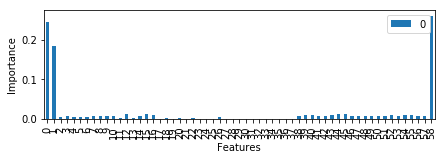

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1111)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [38]:
# ラベルを予測
y_pred_test = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

正答率（Accuracy） = 66.579%


In [39]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])

conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,12584,13878
正解 = 失敗,8278,31553


# アルゴリズム：ニューラルネットワーク

In [40]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7883046947981893552, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11816297256603356835
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4127935734155301566
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14892338381
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8881724951860819340
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [41]:
!cat /etc/issue
import tensorflow as tf
tf.test.gpu_device_name()
!nvidia-smi

Ubuntu 18.04.2 LTS \n \l

Fri Aug  9 01:33:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |    129MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                  

In [42]:
# GPU config
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list="0"
sess = tf.Session(config=config)
K.set_session(sess)
import keras
from keras.models import Sequential
#from tensorflow.compat.v1.keras import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0}))

model = Sequential()
model.add(Dense(8, activation='relu', input_dim=59))
model.add(Dropout(0.2)) #Dropoutで過学習を抑制
model.add(Dense(59, activation='relu', input_dim=8))
model.add(Dropout(0.2)) #Dropoutで過学習を抑制
model.add(Dense(2, activation='softmax'))#出力層は2次元

model.summary()

# ------ 最適化手法 ------
sgd = SGD(lr=1e-3, momentum=0.9, nesterov=False) #確率的勾配降下法
rms = RMSprop(lr=0.01)
adag = Adagrad(lr=0.01)
adad = Adadelta(lr=0.01)
adam = Adam(lr=1e-3) 
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


Using TensorFlow backend.
W0809 01:33:46.159472 140623781046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 01:33:46.168406 140623781046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 01:33:46.171074 140623781046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 01:33:46.190155 140623781046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 59)                531       
_________________________________________________________________
dropout_2 (Dropout)          (None, 59)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 120       
Total params: 1,131
Trainable params: 1,131
Non-trainable params: 0
_________________________________________________________________


W0809 01:33:46.419188 140623781046144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 265169 samples, validate on 66293 samples
Epoch 1/50
265169/265169 [==============================] - 23s 87us/step - loss: 0.6590 - acc: 0.6054 - val_loss: 0.6372 - val_acc: 0.6312
Epoch 2/50
265169/265169 [==============================] - 22s 83us/step - loss: 0.6451 - acc: 0.6233 - val_loss: 0.6345 - val_acc: 0.6379
Epoch 3/50
265169/265169 [==============================] - 22s 84us/step - loss: 0.6416 - acc: 0.6283 - val_loss: 0.6327 - val_acc: 0.6390
Epoch 4/50
265169/265169 [==============================] - 22s 83us/step - loss: 0.6404 - acc: 0.6309 - val_loss: 0.6320 - val_acc: 0.6396
Epoch 5/50
265169/265169 [==============================] - 22s 82us/step - loss: 0.6386 - acc: 0.6323 - val_loss: 0.6321 - val_acc: 0.6407
Epoch 6/50
265169/265169 [==============================] - 22s 82us/step - loss: 0.6380 - acc: 0.6334 - val_loss: 0.6316 - val_acc: 0.6406
Epoch 7/50
265169/265169 [==============================] - 22s 82us/step - loss: 0.6368 - acc: 0.6346 - val_

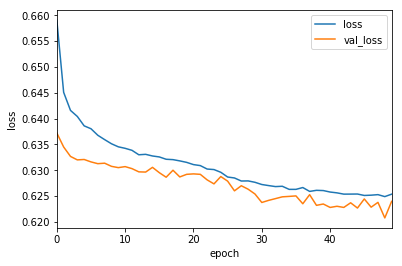

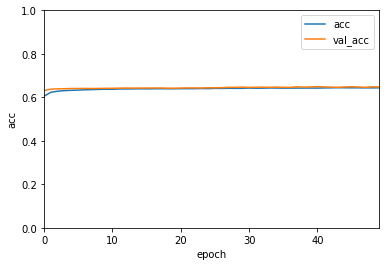

In [43]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [0]:
#  from tensorflow.compat.v1.keras.models import load_model

# # 保存
# model.save('my_model.h5')
# del model

# # 読み込み
# model = load_model('/content/my_model.h5')

In [0]:
# ラベルを予測
y_pred_test = np.argmax(model.predict(X_test),axis=1)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

In [0]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])

conf_mat

# まとめ

## 1回目：とりあえずやってみた
|  アルゴリズム  |  正答率（Accuracy）  |  適合率（Precision）  |  再現率（Recall）  |  F1値（F1-score）  |
| ---- | ---- | ---- | ---- | ---- |
|  ロジスティック回帰  |  65.058%  |  58.435%  |  43.171%  |  49.657%  |
|  SVM  |  計算NG  |  計算NG  |  計算NG  |  計算NG  |
|  ランダムフォレスト  |  60.083%  |  error  |  error  |  error  |
|  ニューラルネットワーク  |  64.420%  |  57.932%  |  39.676%  |  47.097%  |

## 2回目：ハイパーパラメータチューニング
|  アルゴリズム  |  正答率（Accuracy）  |  適合率（Precision）  |  再現率（Recall）  |  F1値（F1-score）  |
| ---- | ---- | ---- | ---- | ---- |
|  ロジスティック回帰  |  64.657%  |  59.230%  |  36.762%  |  45.367%  |
|  SVM  |  計算NG  |  計算NG  |  計算NG  |  計算NG  |
|  ランダムフォレスト  |  66.696%  |  error  |  error  |  error  |
|  ニューラルネットワーク  |  64.416%  |  60.433%  |  31.434%  |  41.356%  |

アルゴリズム変更やハイパーパラメータチューニングしても大きな改善はしなかった。

## 実行環境を変更して計算速度を確認

|  端末  |  s  |  us/sample  |  備考  |
| ---- | ---- | ---- | ---- |
|  PC  |  10.16  |  38  |  numpy  |
|  Google colabratory  |  20.06  |  76.34  |  cupy  |
|  会社サーバ  |  16.02  |  59.98  |  numpy  |

パソコンの方が早いという結果に。
kerasでGPUを使う方法を調査中。。。

## 精度改善に向けて
1. 特徴量の選択の見直し
2. 出来なかったことの対応（外れ値の除去、無相関化・白色化）

## ニューラルネットワークの精度改善について
1. 隠れ層の変更
2. 活性化関数の変更
3. ハイパーパラメータのグリッドサーチorランダムサーチ
4. GPU利用による計算速度向上